# Logistic Regression with `tf.data`

* [참고: TensorFlow.org](https://www.tensorflow.org/get_started/mnist/beginners)
* [소스: mnist_softmax.py in verion 1.4](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_softmax.py)
* `tf.data`를 이용하여 input pipeline을 바꿔보자

### Import modules

In [1]:
"""A very simple MNIST classifier.
See extensive documentation at
https://www.tensorflow.org/get_started/mnist/beginners in version 1.4
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import tensorflow as tf

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

np.random.seed(219)
tf.set_random_seed(219)

### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_labels = np.asarray(test_labels, dtype=np.int32)

### Show the MNIST

label = 5


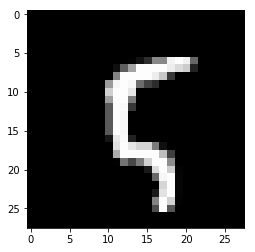

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = 100
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28), cmap='gray')
plt.show()

### Set up dataset with `tf.data`

#### input pipeline `tf.data.Dataset` and Transformation

In [4]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.shuffle(buffer_size = 10000)
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.int32)>


#### Define Iterator

In [5]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
# 여기를 직접 채워 넣으시면 됩니다.
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle, train_dataset.output_types, train_dataset.output_shapes)

# 여기를 직접 채워 넣으시면 됩니다.
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

## Build a graph

### Create weight and bias

In [6]:
# 여기를 직접 채워 넣으시면 됩니다.
# create Variables using `get_variable`
W = tf.get_variable(name='W', shape=[784, 10], initializer=tf.truncated_normal_initializer())
b = tf.get_variable(name='b', shape=[10], initializer=tf.random_normal_initializer())

### Build a model: $y = Wx + b$

In [7]:
# 여기를 직접 채워 넣으시면 됩니다.
y_pred = tf.matmul(x, W) + b

### Define loss function

* [`tf.nn.softmax_cross_entropy_with_logits_v2`](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2)
* [`tf.losses.softmax_cross_entropy`](https://www.tensorflow.org/api_docs/python/tf/losses/softmax_cross_entropy)

In [8]:
# 출처: TensorFlow 공식 문서
# The raw formulation of cross-entropy,
#
#   tf.reduce_mean(-tf.reduce_sum(y * tf.log(tf.nn.softmax(y_pred)),
#                                 reduction_indices=[1]))
#
# can be numerically unstable.
#
# So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
# outputs of 'y', and then average across the batch.
y_one_hot = tf.one_hot(y, depth=10)
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot,
                                                logits=y_pred)

### Create a optimizer

In [9]:
train_op = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### `tf.Session()` and train

In [10]:
start_time = time.time()
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_initializable_iterator()
train_handle = sess.run(train_iterator.string_handle())

max_epochs = 10 # Train for only ten epochs
step = 0
losses = []
start_time = time.time()
for epochs in range(max_epochs):
  sess.run(train_iterator.initializer)
  
  while True:
    try:
      _, loss = sess.run([train_op, cross_entropy],
                         feed_dict={handle: train_handle})
      losses.append(loss)

      if step % 100 == 0:
        print("step: %d, loss: %g" % (step, loss))
      step += 1

    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      break
    
print("training done!")
print("Elapsed time: {}".format(time.time() - start_time))

step: 0, loss: 10.9081
step: 100, loss: 1.62581
step: 200, loss: 0.473462
step: 300, loss: 1.02776
step: 400, loss: 1.14787
step: 500, loss: 0.648653
step: 600, loss: 0.535513
step: 700, loss: 0.683906
step: 800, loss: 0.974797
step: 900, loss: 0.434975
step: 1000, loss: 1.26805
step: 1100, loss: 1.21754
step: 1200, loss: 1.34171
step: 1300, loss: 0.126948
step: 1400, loss: 0.861013
step: 1500, loss: 0.431571
step: 1600, loss: 1.45818
step: 1700, loss: 0.555825
step: 1800, loss: 0.705837
End of dataset
step: 1900, loss: 0.0840894
step: 2000, loss: 1.19313
step: 2100, loss: 0.1841
step: 2200, loss: 0.724616
step: 2300, loss: 1.02807
step: 2400, loss: 0.288195
step: 2500, loss: 0.63546
step: 2600, loss: 0.168137
step: 2700, loss: 1.20409
step: 2800, loss: 0.201409
step: 2900, loss: 0.256565
step: 3000, loss: 0.450206
step: 3100, loss: 0.279107
step: 3200, loss: 0.196603
step: 3300, loss: 0.895472
step: 3400, loss: 0.337283
step: 3500, loss: 0.498716
step: 3600, loss: 0.164274
step: 3700,

### Plot the loss funtion

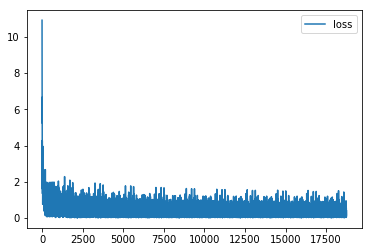

In [11]:
plt.plot(losses, label='loss')
plt.legend()
plt.show()

### Test trained model

In [12]:
# test_iterator
test_iterator = test_dataset.make_initializable_iterator()
test_handle = sess.run(test_iterator.string_handle())
sess.run(test_iterator.initializer)

In [13]:
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("test accuracy:", sess.run(accuracy, feed_dict={handle: test_handle}))

test accuracy: 0.911


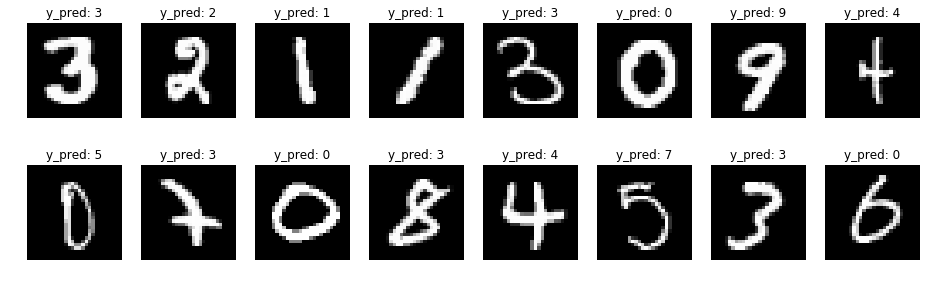

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)
batch_xs = test_data[batch_index]
y_pred_ = sess.run(y_pred, feed_dict={x: batch_xs})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  p.set_title("y_pred: {}".format(np.argmax(py)))
  p.imshow(px.reshape(28, 28), cmap='gray')
  p.axis('off')

## 직접 실습

* 여러가지 hyper-parameter들을 바꿔가면서 accuracy를 높혀보자